# Water Potability

In this analysis, I explored the dataset Water Potability from Kaggle Water-Potability which contains 3276 entries and 9 features that determine the water potability. An extensive explanation of these features is provided on the dataset´s Kaggle page.

The analysis begin with exploratory data analysis (EDA) to understand the data distribution, statistical measures and quality. I found that approximately 11% of data entries are outliers, and around 44% of the data contain missing values. To prepare the data for modeling, I followed the multi-step preprocessing approach:

* Outlier treatment using IQR capping to reduce the impact of extreme values.

* Missing value imputation using the k-Nearest Neighbors (kNN) algorithm.

For modeling, I implemented two machine learning classifiers:

* Support Vector Machine (SVM): Before imputation, I applied a RobustScaler to mitigate the effect of outliers during scaling.

* Random Forest: Since tree-based models are less sensitive to feature scaling, I skipped scaling for this model.

**Objective**

Predict the potability of the water based on the values of its features: pH, hardness, solids, chloramines, sulfate, conductivity, organic carbon, trihalomethanes, and turbidity.

Import libraries

In [1]:
# Basic modules
import numpy as np
import pandas as pd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
import scipy.stats as stats
from scipy.stats import skew

# library from preprocessing Module.
from sklearn.preprocessing import  RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# SVM
from sklearn import svm
from sklearn.svm import SVC

# Evalation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,  recall_score
from sklearn.model_selection import validation_curve


# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')

## 1) Download data

In [2]:
# Read the CSV file using the correct path
df = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

### a) General and statistical information

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
# General information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


* The dataset contains 3,276 rows and 10 columns.
* There are missing values in columns *ph, Sulfate* and *Trihalomethanes*.

### b) Distribution of Potability classes

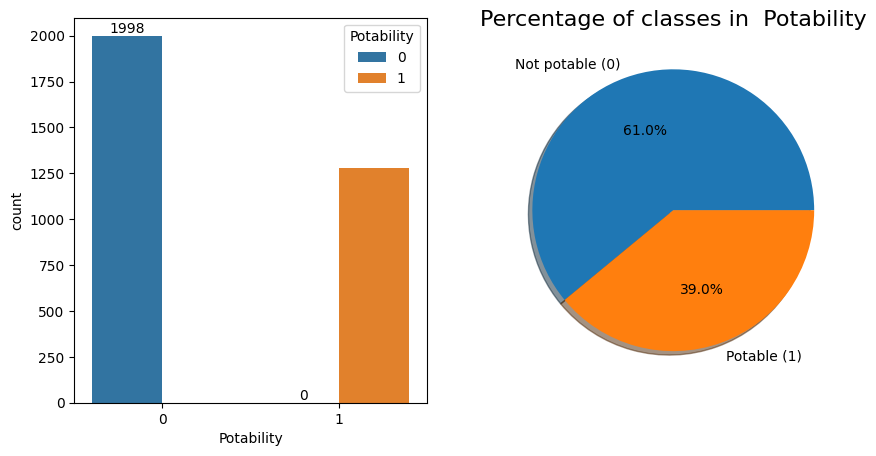

In [5]:
# Counting the number of classes in Rain

fig, ax = plt.subplots(1,2,figsize=(10,5))

# bar plot
# Use the original 'Potability' column for the countplot
ax = sns.countplot(data=df, x="Potability",ax=ax[0], hue = "Potability")
ax.bar_label(ax.containers[0])

#pie plot
# Use value_counts() directly on the 'Potability' column
# Map the integer values to desired labels for the pie chart
potability_counts = df['Potability'].value_counts()
potability_labels = {0: 'Not potable (0)', 1: 'Potable (1)'}
# Apply the mapping to the index of the value counts Series
potability_counts.index = potability_counts.index.map(potability_labels)

# Plot the pie chart using the re-indexed value counts
potability_counts.plot.pie(autopct='%1.1f%%', shadow=True, textprops={'fontsize': 10}, ylabel='')

plt.title('Percentage of classes in  Potability', fontsize=16)
plt.show()

### c) Distribution information

In [6]:
# Statistical information
# Pandas ignores NaN values by default when calculating descriptive statistics.
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000



* For Solids, the difference between the minimum and maximum values spans up to three orders of magnitude compared to the other columns.
  
* The variables have different ranges; in particular, the *Solids* feature has a significantly larger range of values than the rest.

* By comparing the mean and median (50th percentile), we observe a small gap between them in the *Solids* column, indicating a positively skewed distribution.
In contrast, the remaining columns exhibit Gaussian-like distributions, as the differences between their means and medians are minimal.


The following distribution plots support the last three observations.

### d) Visualization

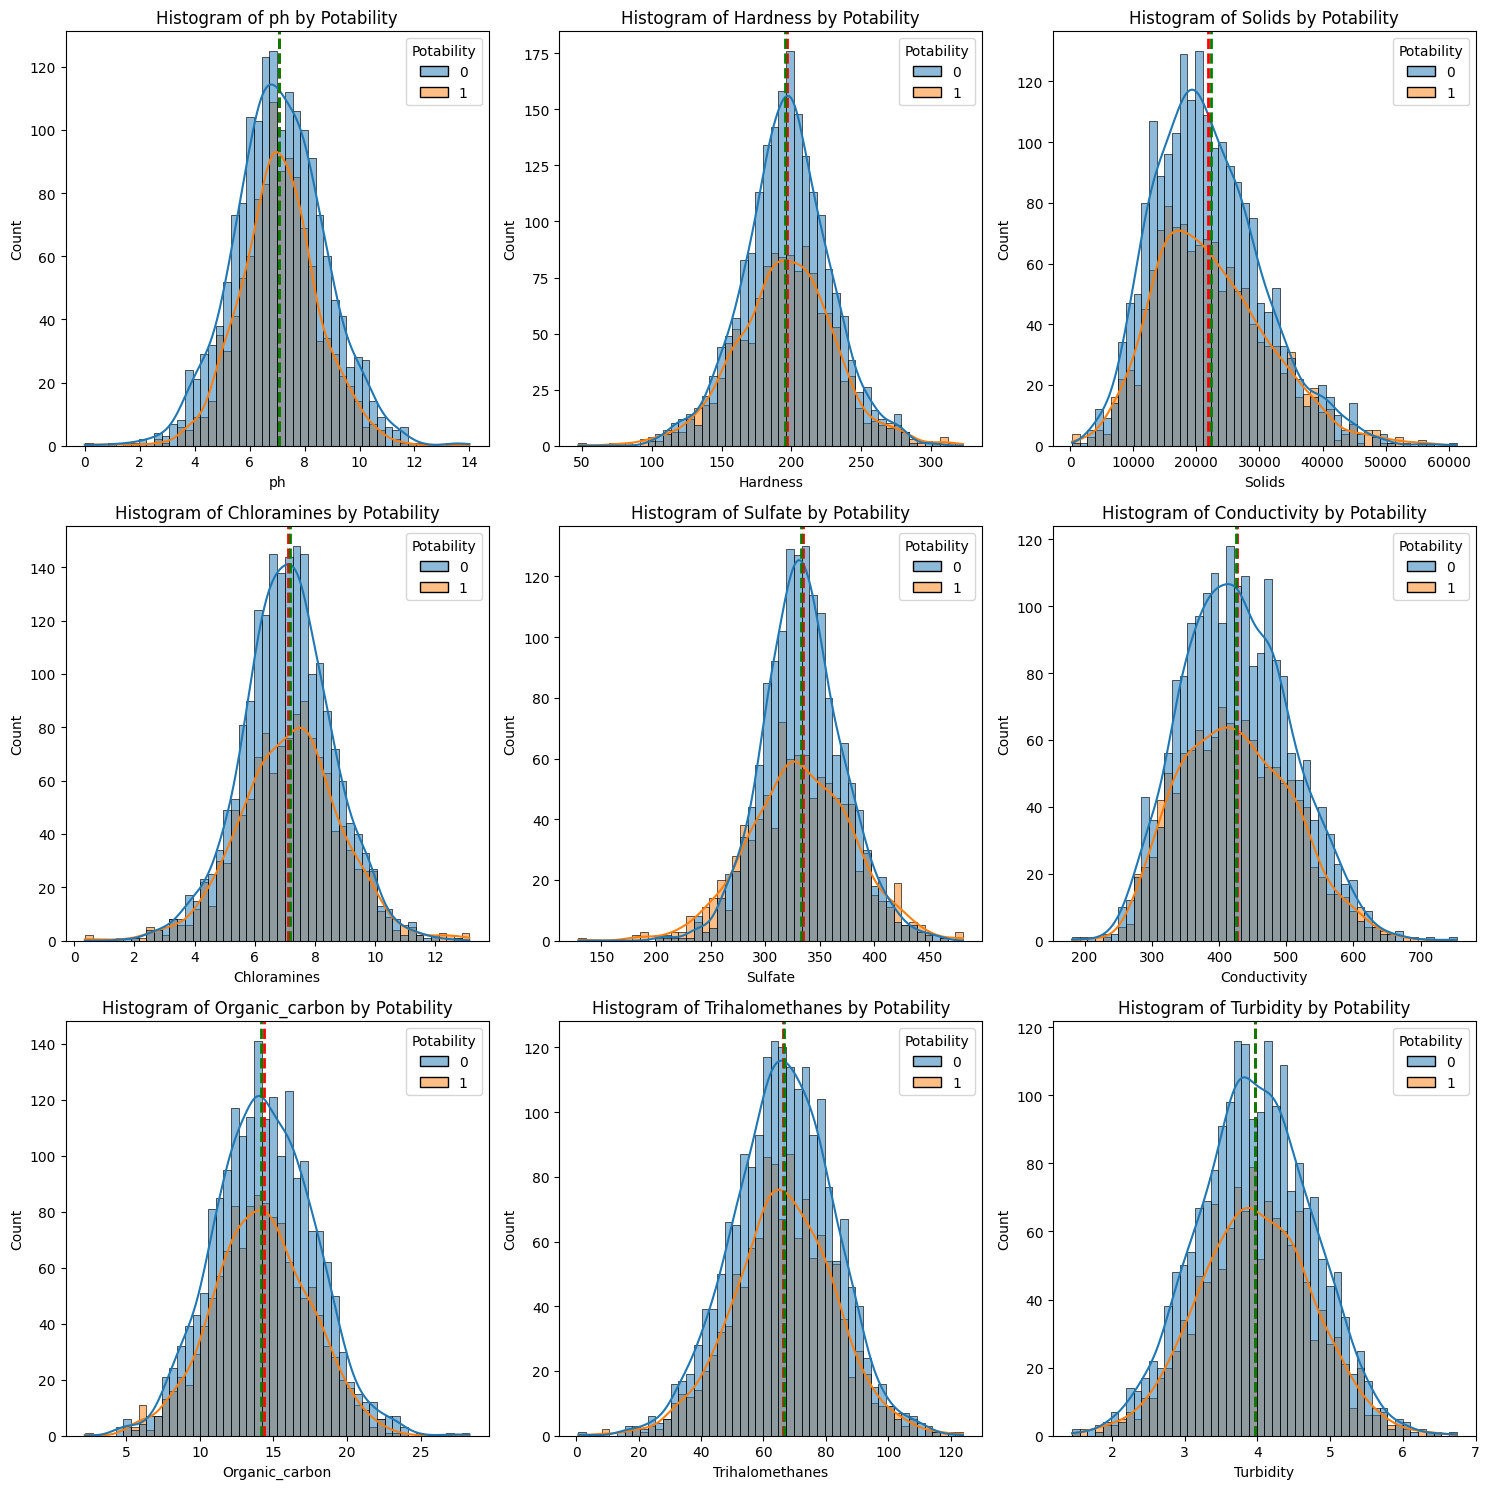

In [7]:
# Histograms with hue for Potability
plt.figure(figsize=(15, 15))

# Change the subplot grid to 3x3 to accommodate 9 plots
for i, col in enumerate(df.columns[:-1]):  # Exclude the last column (Potability)
    plt.subplot(3, 3, i + 1)  # Changed from 3x2 to 3x3
    # Removed legend_out=True as it's not a valid argument for histplot
    sns.histplot(data=df, x=col, hue='Potability', kde=True, bins=50)
    plt.title(f'Histogram of {col} by Potability')

    # Calculate the mean for the current column, grouped by 'Potability'
    mean_col_values = df.groupby('Potability')[col].mean()

    # Add the mean lines for the current column for each 'Potability' category
    # Access the mean value for not potable and potable separately
    plt.axvline(mean_col_values[0], color='red', linestyle='--', linewidth=2, label='Mean (not pot)')
    plt.axvline(mean_col_values[1], color='green', linestyle='--', linewidth=2, label='Mean (pot)') # Using a different color for clarity
    #plt.legend(loc="upper left") # Add legend here to show the mean label on each subplot
    


plt.tight_layout()
plt.show()

The distribution for *Solids* shows a moderate positive skew, as the tail on the right side is longer than the tail on the left. *Conductivity* also exhibits a slight positive skew. The remaining columns display only minimal skewness, which is small enough that their distributions can be considered approximately Gaussian.

In [8]:
# compute the skewness
df.groupby(['Potability']).skew(skipna = True)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
Potability,,,,,,,,,
0,0.041441,-0.021491,0.606185,-0.022291,0.118335,0.258431,0.068941,-0.096665,-0.009198
1,-0.018147,-0.046125,0.628156,-0.019584,-0.111839,0.274961,-0.051783,-0.063766,-0.005676


### e) Scatter Plots

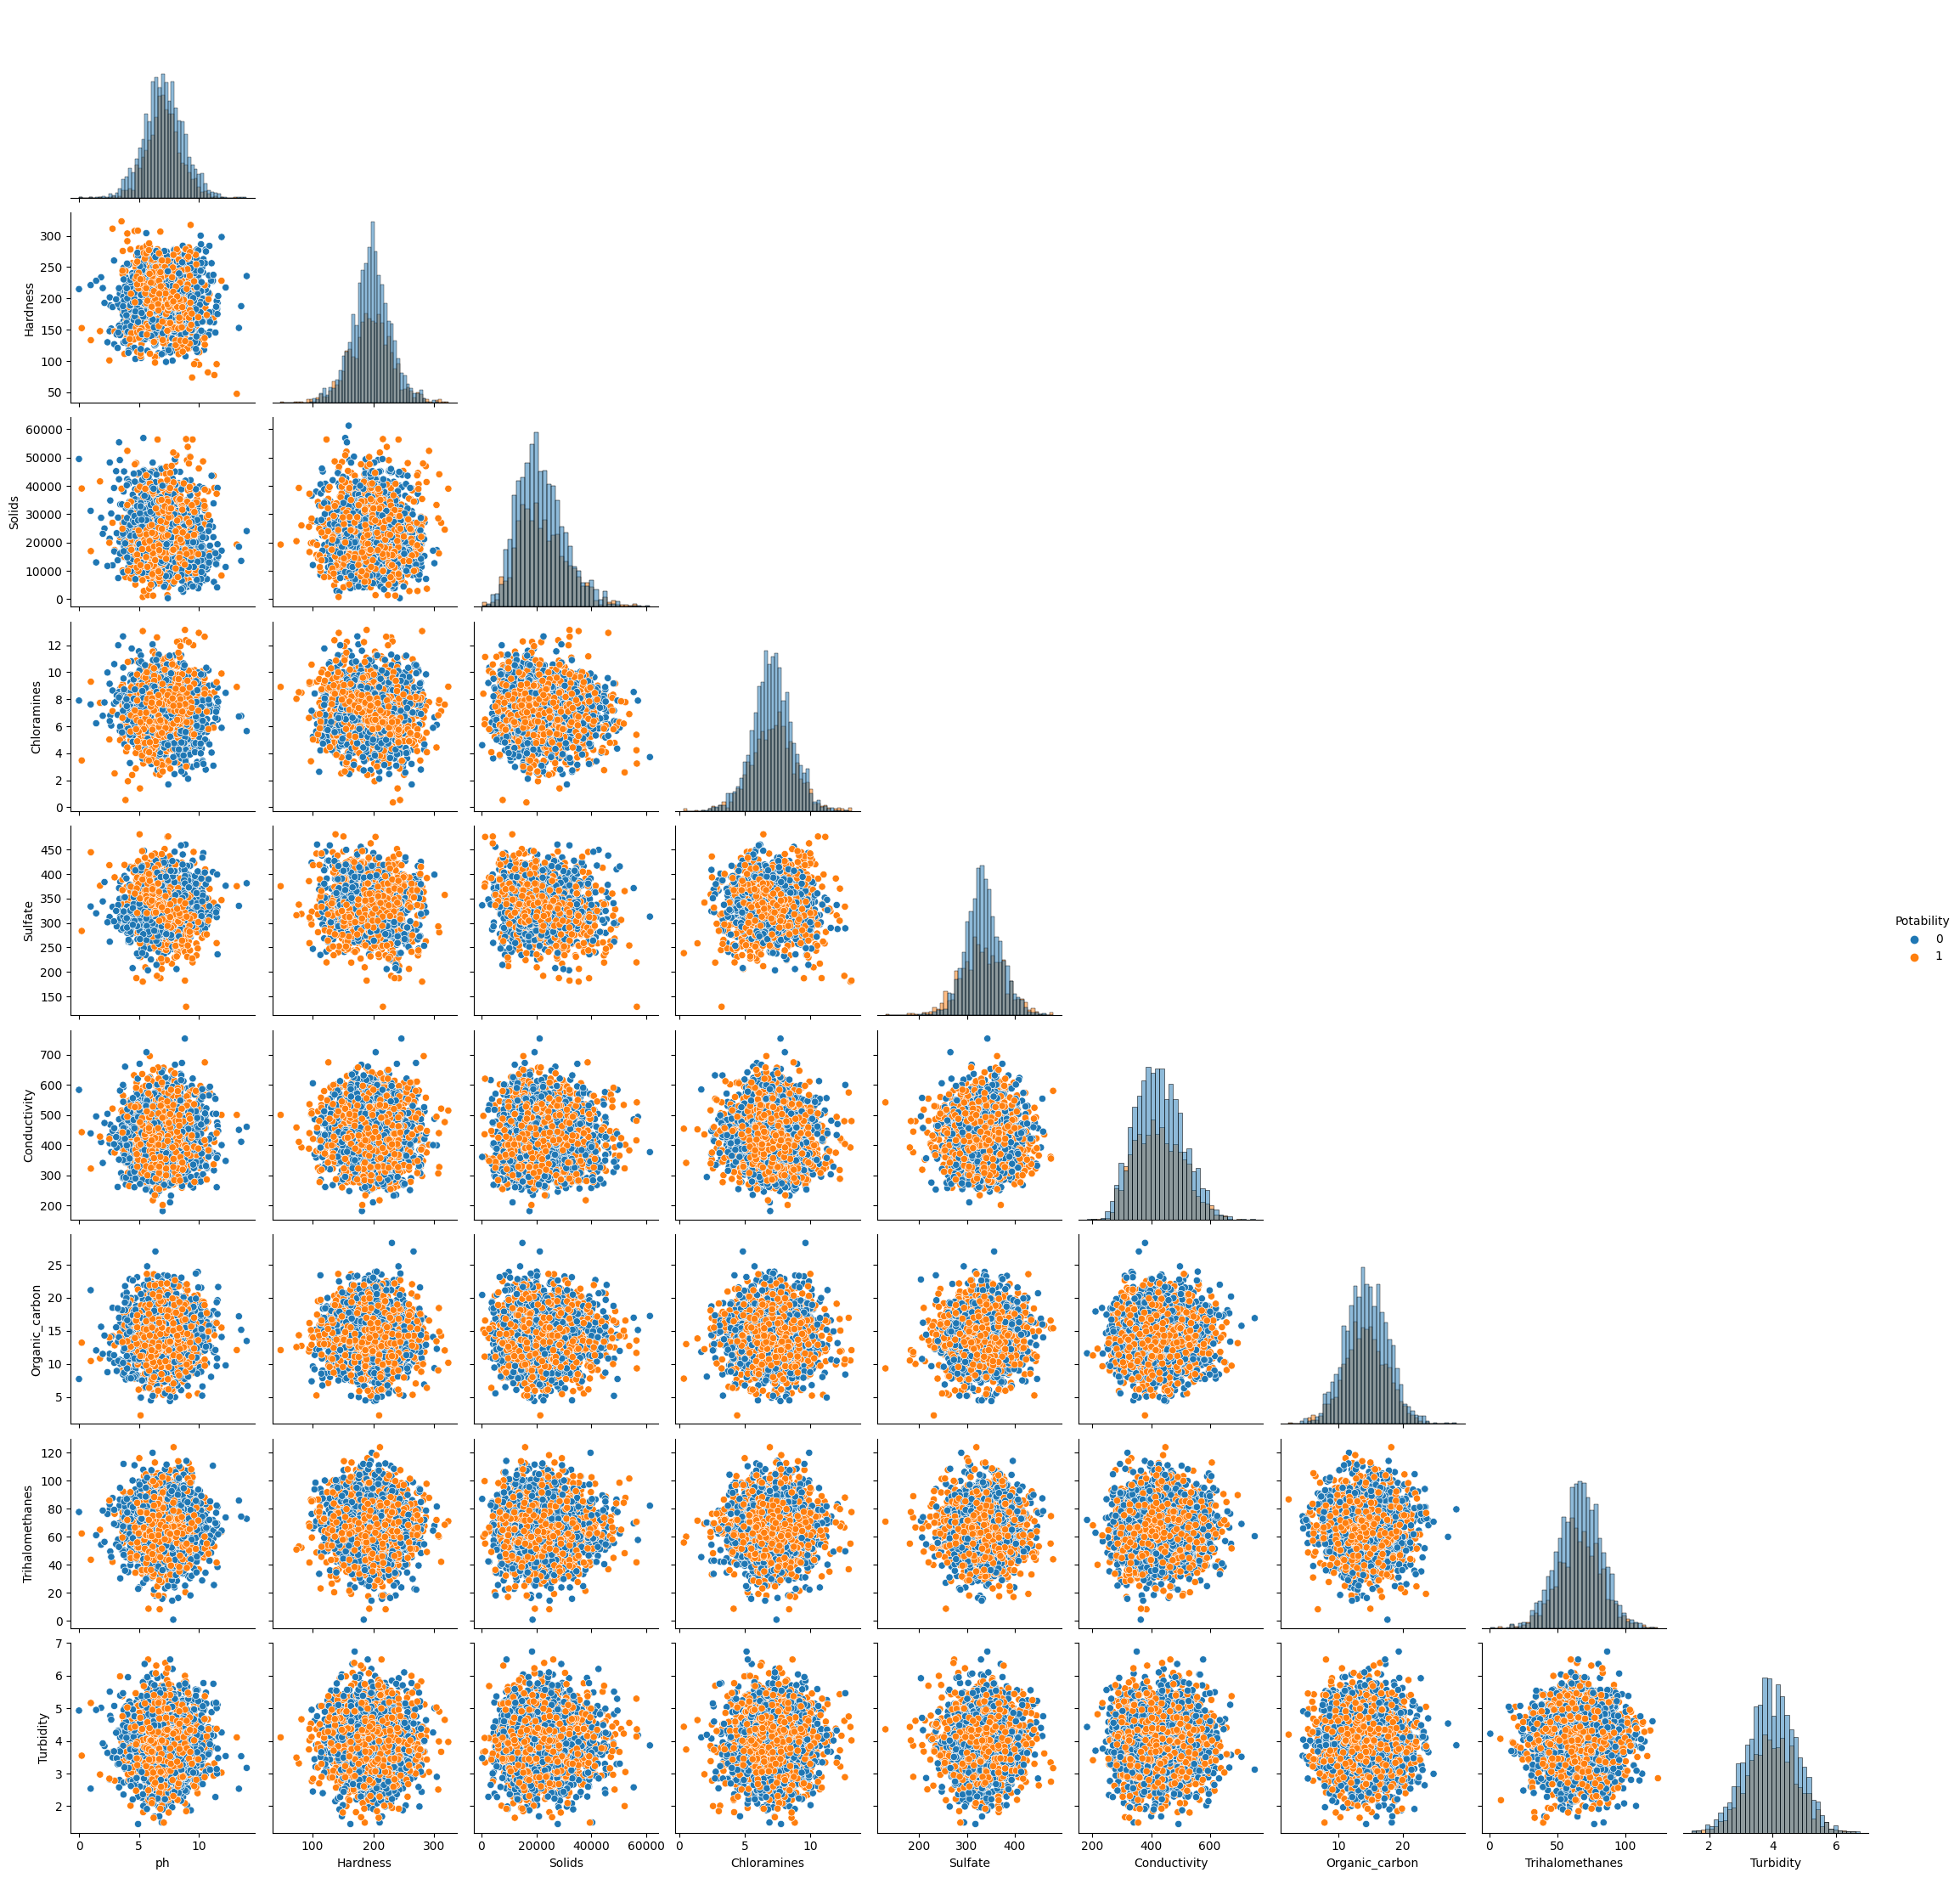

In [9]:
sns.pairplot(df, hue='Potability', corner = True, diag_kind="hist")
plt.show()

### f) Correlation between columns

There is no correlation between the several columns.

In [10]:
# heatmap with mask to avoid nan values
df.corr(method='pearson').style.background_gradient(cmap='coolwarm')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


### g) Missing Values

In [11]:
# The number of missing values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [12]:
# Percentage of missing values
missing_percentage_ph = (df['ph'].isnull().sum() / len(df)) * 100
missing_percentage_sf = (df['Sulfate'].isnull().sum() / len(df)) * 100
missing_percentage_tr = (df['Trihalomethanes'].isnull().sum() / len(df)) * 100
missing_percentage_total = (df.isnull().sum().sum() / len(df)) * 100

print(f"Porcentage of missing values in  'ph':  {missing_percentage_ph:.2f}%")
print(f"Porcentage of missing values in  'Sulfate':  {missing_percentage_sf:.2f}%")
print(f"Porcentaje  of missing values in 'Trihalomethanes':  {missing_percentage_tr:.2f}%")
print(f"Total Porcentaje  of missing values:  {missing_percentage_total:.2f}%")

Porcentage of missing values in  'ph':  14.99%
Porcentage of missing values in  'Sulfate':  23.84%
Porcentaje  of missing values in 'Trihalomethanes':  4.95%
Total Porcentaje  of missing values:  43.77%


Before handling missing values, we need to understand their pattern of occurrence.

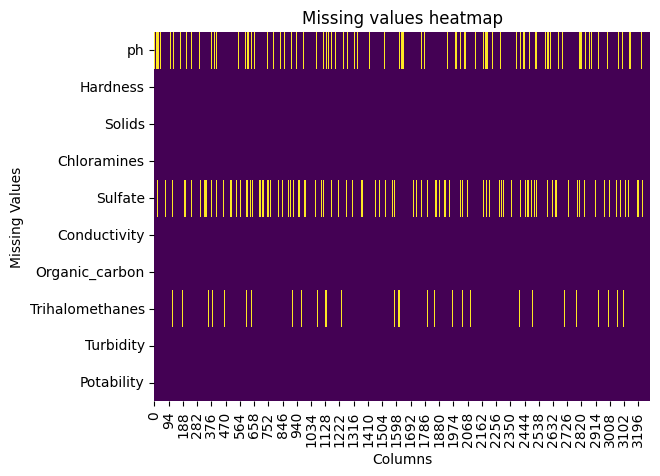

In [13]:
#set figure size
#plt.figure(figsize=(6,6))
ax = plt.axes()
sns.heatmap(df.isna().transpose(),cbar=False, cmap = "viridis",ax = ax)
plt.xlabel("Columns", fontsize = 10)
plt.ylabel("Missing Values", fontsize = 10)
#labels and titles
plt.title("Missing values heatmap")
plt.show()

The missing values in *pH* appear in chunks, while in *Sulfate* they are more evenly distributed across the rows. In *Trihalomethanes*, the missing values are sparsely scattered. Overall, no clear pattern is evident in the missing data.

Are the missing values distributed along the two classes? Yes, they are.

In [14]:
df.isnull().groupby(df['Potability']).sum()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Potability,,,,,,,,,,
0,314,0,0,0,488,0,0,107,0,0
1,177,0,0,0,293,0,0,55,0,0


### h) Outliers

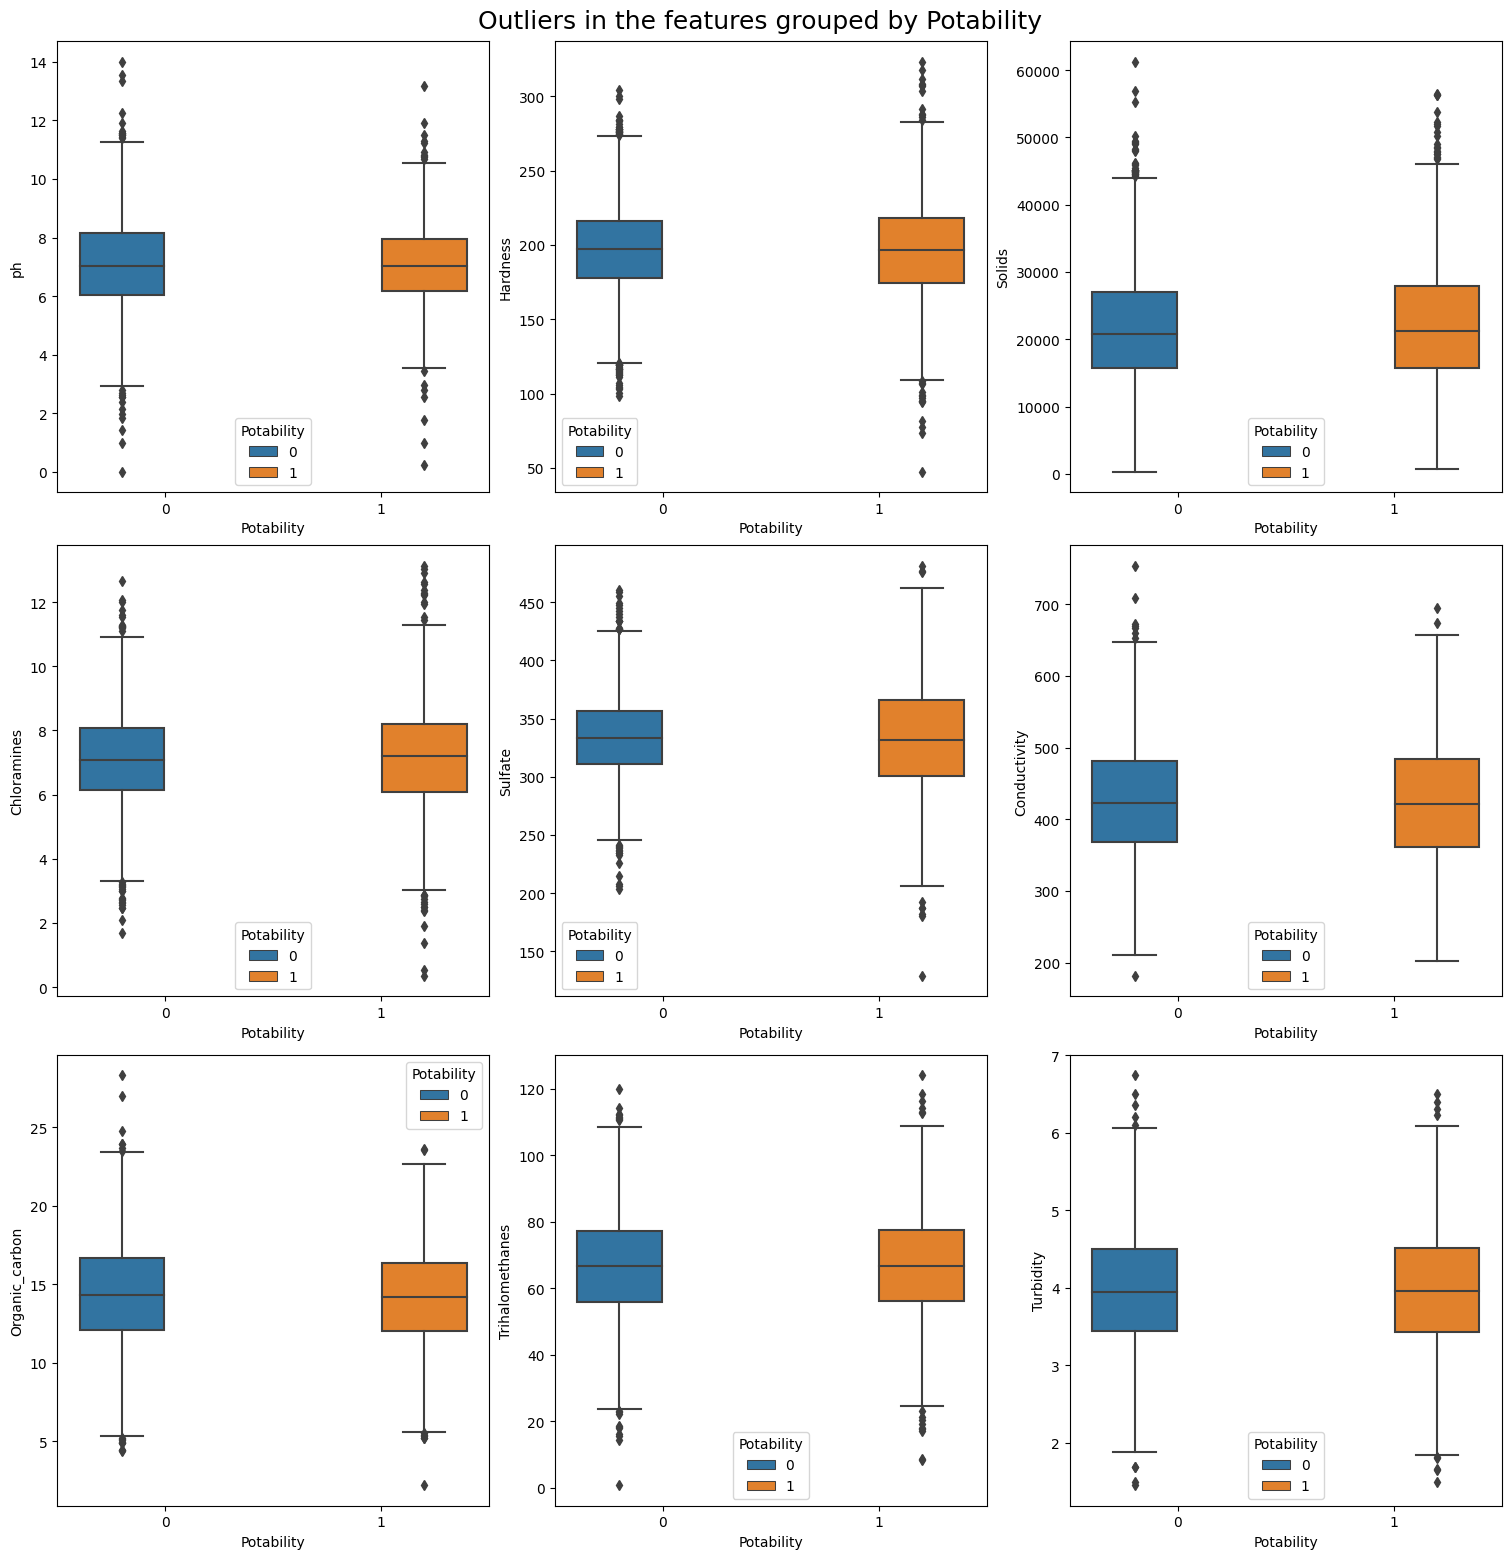

In [15]:
# Change the subplot grid to 4x3 to accommodate 10 plots
fig, axes = plt.subplots(4, 3, constrained_layout=True, figsize=(15, 20)) # Increased figure size for better readability
axes = axes.flatten()

# List of columns to plot (excluding the duplicate 'Conductivity')
columns_to_plot = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]

# Loop through the columns and plot
for i, col in enumerate(columns_to_plot):
    sns.boxplot(x="Potability", y=col, data=df, orient='v',  ax=axes[i], hue = "Potability" )

# Hide any unused subplots (since 10 < 12)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(" Outliers in the features grouped by Potability", fontsize = 18)
plt.show() # Add plt.show() to display the plots

 *Hardness* is the columns with the most number of outliers.

In [16]:
# Count outliers
def outliers(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
  return outliers

In [17]:
outliers_df = outliers(df)
pd.DataFrame({"Count.Outliers": outliers_df.sum(),
            "Pct.Outliers %": (outliers_df.sum() * 100/ len(df)).round(2)})

,Count.Outliers,Pct.Outliers %
ph,46,1.40
Hardness,83,2.53
Solids,47,1.43
Chloramines,61,1.86
Sulfate,41,1.25
Conductivity,11,0.34
Organic_carbon,25,0.76
Trihalomethanes,33,1.01
Turbidity,19,0.58
Potability,0,0.00


In [18]:
print(f" Total percentage of outliers: {((outliers_df.sum().sum()/ len(df)) * 100):.2f} %")

 Total percentage of outliers: 11.17 %



This dataset has 43.8 % of missing values and 11.17 % of outliers.

Because the number of outliers is less than the number of missing values, first I deal with outliers.

## 3) Preprocessing

### a) Capping Outliers with Inter Quantile Range (IQR)

In [19]:
# apply cap with IQR
def cap_outliers_iqr(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = ((df < lower_bound) | (df > upper_bound))
  return np.clip(df, lower_bound, upper_bound)

df_cap_iqr = df.groupby('Potability').transform(cap_outliers_iqr)

### b) Separate data into features and target

In [20]:
# separate data
X= df_cap_iqr
y=df["Potability"]

### c) Splitting data and applying robust scaler


I selected K-Nearest Neighbors (KNN) for imputing the missing values. To do this, I first scaled the data, as KNN is sensitive to the scale of features. The target variable in this analysis is Potability.
I used Robust Scaler since it scale features using statistics that are robust to outliers.

In [21]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler with Robust Scaler
scaler = RobustScaler( with_scaling=True, with_centering = True, quantile_range=(25.0, 75.0))

# scaler fit and transform
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.fit_transform(X_test, y=None)

### d) K-Nearest Neighbors (KNN) imputation of missing values

In [22]:
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=10, weights="uniform") # default values for weights = uniform and metric = nan_euclidean

# Apply KNN imputation, fit and transform
X_train_trf = imputer.fit_transform(X_train_scaled)
X_test_trf = imputer.transform(X_test_scaled)

# Verify that missing values are gone
print("\nMissing values after KNN imputation:")
print(sum(np.isnan(X_train_trf)))



Missing values after KNN imputation:
[0 0 0 0 0 0 0 0 0]


In [23]:
print(sum(np.isnan(X_test_trf)))

[0 0 0 0 0 0 0 0 0]


## 4) Support Vector Machin (SVM)

### a) Linear kernel

In [24]:
# Create the model: linear model
linear_model = SVC(kernel='linear',C=0.5)

# Train the model with the training data
linear_model_train = linear_model.fit(X_train_trf, y_train)

# Predict with the test data
y_pred_linear = linear_model_train.predict(X_test_trf)

In [25]:
# Calculating the accuracy of the linear model
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {accuracy_linear:.2f}")

# Displaying confusion matrix and classification report for the linear model
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
class_report_linear = classification_report(y_test, y_pred_linear)

print("\nConfusion Matrix (Linear SVM):")
print(conf_matrix_linear)
print("\nClassification Report (Linear SVM):")
print(class_report_linear)

Linear SVM Accuracy: 0.63

Confusion Matrix (Linear SVM):
[[412   0]
 [244   0]]

Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



The linear SVM is evidently ineffective, as it fails to identify any true positives.

## b) Radial Basic Function (RBF) kernel

In [26]:
# Create a RBF model classifiers
rbf_model = SVC(kernel='rbf', C=0.1,class_weight='balanced', gamma = 0.1)

# Train the model with the training data
rbf_model_train = rbf_model.fit(X_train_trf, y_train)

# Predict with the test  and train
y_test_pred_rbf = rbf_model_train.predict(X_test_trf)
y_train_pred_rbf = rbf_model_train.predict(X_train_trf)

In [27]:
# Evaluation of the classification

svm_classification = classification_report(y_test, y_test_pred_rbf)
print(svm_classification)

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       412
           1       0.54      0.34      0.42       244

    accuracy                           0.65       656
   macro avg       0.61      0.58      0.58       656
weighted avg       0.63      0.65      0.62       656



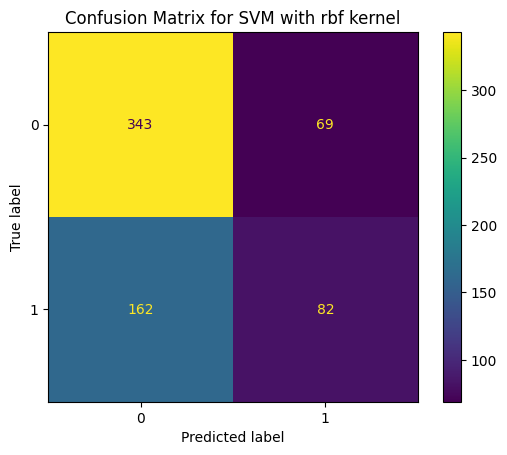

In [28]:
# Calculate the confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_rbf)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for SVM with rbf kernel")
plt.show()

This model performs better than the linear. The number of true positives is 82 and false negatives 69. Below I show the validation curves that helped me to select the best values of the hyperparameters. 


#### Tuning the hyperparameters

Best C value based on testing accuracy: 0.1
Corresponding training accuracy: 0.69
Corresponding testing accuracy: 0.65


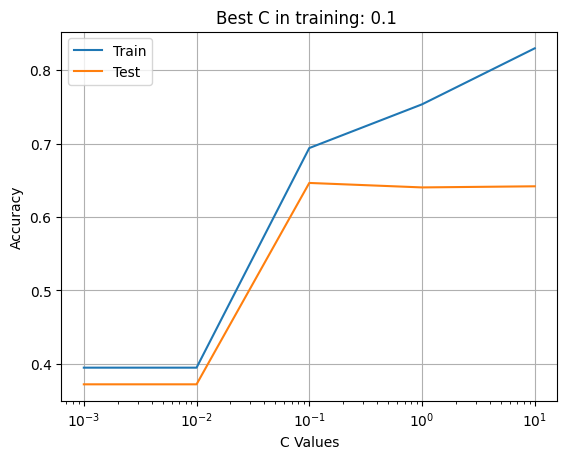

In [29]:
# list to record the accuracy
training_accuracy = []
testing_accuracy = []

# list to record the error
training_error = []
testing_error = []

# C Hyperparameter - Define a list of specific C values
C_param = [0.001, 0.01, 0.1, 1.0, 10.0]


for C_value in C_param:
    # Create the SVC model with the current C_value
    rbf_model = SVC(kernel='rbf', C=C_value,class_weight='balanced')
    rbf_model_train = rbf_model.fit(X_train_trf, y_train)

    # Appending the Accuracy Score - Use scaled data for evaluation
    training_accuracy.append(rbf_model_train.score(X_train_trf, y_train))
    testing_accuracy.append(rbf_model_train.score(X_test_trf, y_test))

    # Appending the Error Score
    training_error.append(1 - rbf_model_train.score(X_train_trf, y_train))
    testing_error.append(1 - rbf_model_train.score(X_test_trf, y_test))

# Find the best C based on testing accuracy
best_C_index = np.argmax(testing_accuracy)
best_C = C_param[best_C_index]

print(f"Best C value based on testing accuracy: {best_C}")
print(f"Corresponding training accuracy: {training_accuracy[best_C_index]:.2f}")
print(f"Corresponding testing accuracy: {testing_accuracy[best_C_index]:.2f}")



def plot_log(X_values, train_values, test_values, Xlabel, ylabel, title):
    plt.semilogx(X_values, train_values, X_values, test_values)
    plt.xlabel(Xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(("Train", "Test"))
    plt.grid()
    plt.show()


plot_log(C_param, training_accuracy, testing_accuracy, "C Values", "Accuracy", title=f"Best C in training: {best_C:1g} ")

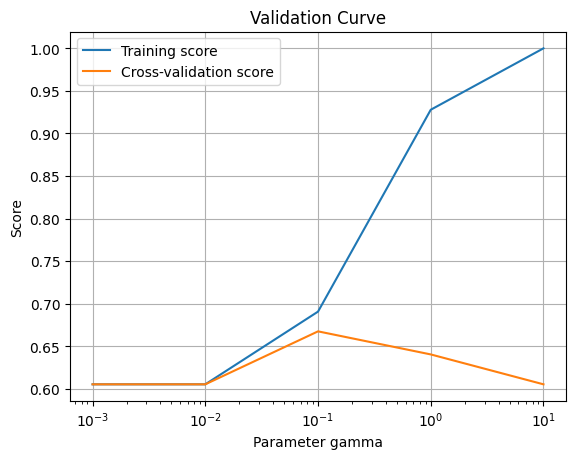

In [30]:
# Example: Validation curve for SVC

# gamma values
gamma_param = [0.001, 0.01, 0.1, 1.0, 10.0]

# compute validation curve
train_scores, test_scores = validation_curve(
     SVC(kernel="rbf"), 
     X_train_trf, y_train,
     param_name="gamma", 
     param_range = gamma_param,
     scoring="accuracy", 
     cv=5
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.semilogx(gamma_param, train_scores_mean, label="Training score")
plt.semilogx(gamma_param, test_scores_mean, label="Cross-validation score")
plt.title("Validation Curve")
plt.xlabel("Parameter gamma")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()


For $C > 0.1$ the training score is high and the validation score is low, the estimator is overfitting. For $ C < 10^{-2}$ the training score and the validation score are both low, the estimator will be underfitting. The best value is $C = 0.1$. From the validation curve for $\gamma$ we also have the best values $\gamma = 0.1$

Next, the KDE plot illustrates the probability distributions of the actual and predicted values. There is a visible gap between the curves  where potability equals 1. This gap indicate that the model’s predicted values differ noticeably from the true values for the potable class  and that the model isn't capturing the underlying distribution well for that class, signaling room for improvement.

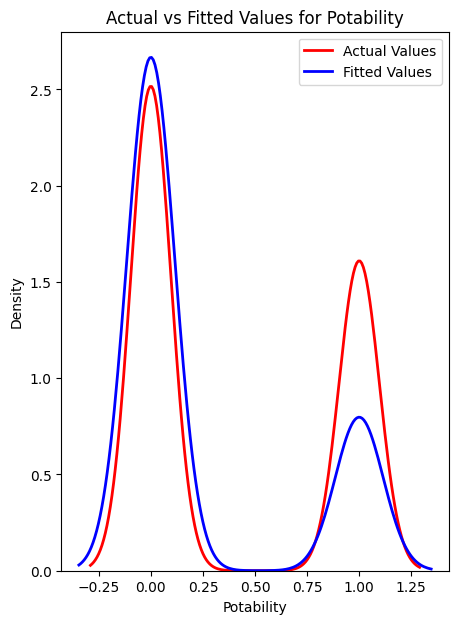

In [31]:
plt.figure(figsize=(5, 7))

# Plot actual values
ax = sns.kdeplot(y, color="r", label="Actual Values", linewidth=2)

# Plot predicted values
sns.kdeplot(y_test_pred_rbf, color="b", label="Fitted Values", ax=ax, linewidth=2)

# Add labels and title
plt.title('Actual vs Fitted Values for Potability')
plt.xlabel('Potability')
plt.ylabel('Density')

# Add legend with location specified
plt.legend(loc='upper right')

# Show and close plot
plt.show()
plt.close()

In [32]:
model = SVC(kernel='rbf', C=0.1,class_weight='balanced', gamma = 0.1, probability=True)
# Train the model with the training data
model.fit(X_train_trf, y_train)
proba_pred = model.predict_proba(X_test_trf)

# Probability
prob_pot_svm = pd.DataFrame(proba_pred, columns=['P(y=0|X)', 'P(y=1|X)'])
prob_pot_svm.head(15)

,P(y=0|X),P(y=1|X)
0,0.753412,0.246588
1,0.706201,0.293799
2,0.692096,0.307904
3,0.545095,0.454905
4,0.658189,0.341811
5,0.396955,0.603045
6,0.573721,0.426279
7,0.451179,0.548821
8,0.454942,0.545058
9,0.691947,0.308053


## 5) Random Forest

With the aim of improving model performance, I have implemented a Random Forest classifier as an alternative to the SVM

Standarization or normalization is not needed for tree bases models. Therefore, I just consider the missing values imputation.

In [33]:
# Create an instance of KNNImputer without scale
imputer_knn = KNNImputer(n_neighbors=10, weights="uniform") # default values for weights = uniform and metric = nan_euclidean

# Apply KNN imputation, fit and transform
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Verify that missing values are gone
print("\nMissing values after KNN imputation:")
print(sum(np.isnan(X_train_imp)))


Missing values after KNN imputation:
[0 0 0 0 0 0 0 0 0]


#### Tuning the hyperparameters
Looking for the best model for different values of the hyperparameters.

In [34]:
param_dist = {'n_estimators': randint(5,25),
              'max_depth': randint(1,30)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 42,criterion='gini')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_imp, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 23}


In [35]:
# Construct the model  with the best hyperparameters
rf_model = RandomForestClassifier(random_state = 42,  **rand_search.best_params_)

# Fit model with the training data.
rf_model.fit(X_train_imp, y_train)

# prediction of the rf model
y_pred =rf_model.predict(X_test_imp)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(y_test, y_pred)

In [36]:
# Evaluation of the classification
rf_classification = classification_report(y_test, y_pred)
print(rf_classification)


              precision    recall  f1-score   support

           0       0.68      0.95      0.79       412
           1       0.76      0.25      0.37       244

    accuracy                           0.69       656
   macro avg       0.72      0.60      0.58       656
weighted avg       0.71      0.69      0.64       656



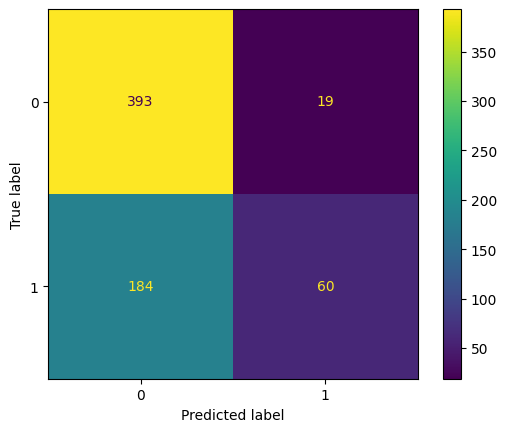

In [37]:
# Generate predictions with the best model
y_pred_set = best_rf.predict(X_test_imp)

# Create the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot();

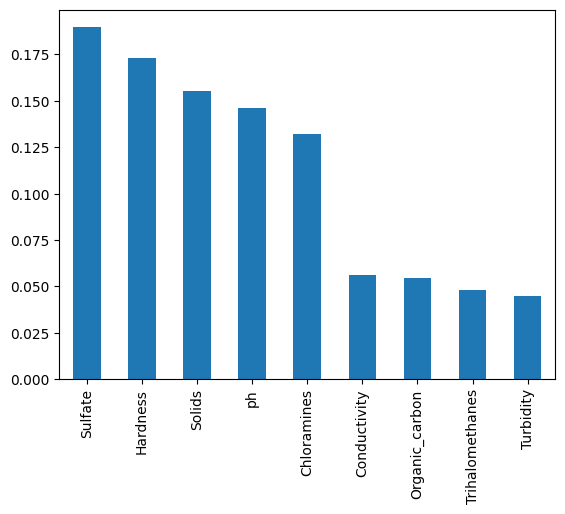

In [38]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [39]:
# Probability
prob_pot_rf = pd.DataFrame(rf_model.predict_proba(X_test_imp), columns=['P(y=0|X)', 'P(y=1|X)'])
prob_pot_rf.head(15)

,P(y=0|X),P(y=1|X)
0,0.661110,0.338890
1,0.642089,0.357911
2,0.620348,0.379652
3,0.588740,0.411260
4,0.585565,0.414435
5,0.113817,0.886183
6,0.559763,0.440237
7,0.712184,0.287816
8,0.511570,0.488430
9,0.624553,0.375447


## 6) Conclusions

* Between the two models, SVM achieved a test accuracy of 0.65, while Random Forest performed better with a test accuray of 0.70.


*  Contaminated water have severe risk, like disease an even dead. Therefore, reducing false positives in the model is important. Compared to the SVM model, the Random Forest model reduced the number of false positives from 69 to 18, which is a significant improvement.


## 7) References

1. [CF_Blog](https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/)
2. [Outliers](https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python)
3. [Normalization-Standarization](https://pmc.ncbi.nlm.nih.gov/articles/PMC3489534/#:~:text=We%20suggest%20that%20normalization%20be,imputation%2C%20significance%20analysis%20and%20visualization)
4. [Normalize after or before imputation](https://stats.stackexchange.com/questions/214728/should-data-be-normalized-before-or-after-imputation-of-missing-data)
5. [Medium_SVM](https://medium.com/data-science/svm-support-vector-machine-for-classification-710a009f6873)